# Applied Economic Analysis 1: Python assignment


|Name|examnr.|
|----|-------|
|Koen van den Bosch|1259425|
|Martijn Bloemberg|2030381|


# Abstract

We analyze crime data of San Francisco in to create insights useful for predictive policing. Using the k-means clustering method, we aim to find correlations in the data between the location of the crime and the type of crime, time of occurrence and day of occurence. When allowing for one cluster per category, the location of the clusters hardly differs. When allowing for 2 or 3 clusters per category we can see a little more spread, but it is hard to draw any solid conclusions from that.

## Research Question
_**Can we find correlations between the location of criminal activity and the hour of occurrence, day of occurrence and/or type of this particular criminal activity?**_


**Motivation of the problem**<br>
Governments are always looking for ways to increase efficiency to reduce costs, and thereby the budget deficit. If we can find correlations between the location of criminal activity and the hour/day of occurrence and/or the type of this particular criminal activity, we can use this to develop what is called 'predictive policing'. Instead of police responding to crime after being alerted, police can be deployed at certain times or in certain areas flagged by our analysis to prevent crime from happening in the first place. Besides efficiency, the police can also be used more effectively. If a certain area is found to be a hotspot for drug related crime, the police can deploy specialized drug teams (such as the DEA) in that specific area. Or if we find that in a certain time period, say 1 till 3 a.m., substantially more crimes are committed in a certain area, say the city center, this calls for increased resources between 1 and 3 a.m. in the city center. Below you can watch a nice video that explains a little more about the concept of predictive policing. (Note: This video also discusses a 'tree based' approach to assign risk to grid cells, this is something we will not be doing here)

In [57]:
from IPython.display import YouTubeVideo
YouTubeVideo("YxvyeaL7NEM")

What we hope to find out is: 
 - Is there a correlation between the location of crime and the type of crime in San Francisco
 - Is there a correlation between the location of crime and the time of occurrence in San Francisco 
 - Is there a correlation between the location of crime and the day of occurrence in San Francisco

If we can find a correlation based on the type of crime or the time/day of occurrence, the police can use this knowledge to allocate their resources more efficiently (predictive policing). If we find that a certain area is a hotspot for drug related crime, the police can deploy specialized teams in that specific area. If we find that during a certain time period, say 21 p.m. till midnight, substantially more crimes are committed in a certain area, this calls for increased resources in that area at that specific time period.

**Proposed method**<br>
After some exploratory data analysis, we will use the k-means clustering algorithm to find an answer to our research question. We will explain the k-means method in depth later on.

## Data Collection
We retrieved our data from _https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry_,
<br> Here we find a large dataset containing records of all crimes committed in San Francisco in the period between January 2003 and May 2018. For every entry, the exact location/coordinates, the time/date of occurence and the category of the crime has been recorded. This dataset has 2.21 million entries, which is what made the notebook crash when we tried to load the file. Therefore we decided to shrink the data file, leaving us with 7348 observations. We first randomized the order of the observations, and then picked the first 7348 observations. We considered this to be enough datapoints for our analysis, yet not too much that the jupyter notebook would have trouble dealing with it. Because we randomized we made sure to have observations from every time period that was in the original dataset.

# Importing packages

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd 
import csv
import datetime
from sklearn.cluster import KMeans
from collections import Counter

%matplotlib inline
import seaborn as sns; sns.set()

# Importing data and data formatting

In [59]:
crime = pd.read_csv("finaldataset.csv")

In [60]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7348 entries, 0 to 7347
Data columns (total 13 columns):
IncidntNum    7348 non-null int64
Category      7348 non-null object
Descript      7348 non-null object
DayOfWeek     7348 non-null object
Date          7348 non-null object
Time          7348 non-null object
PdDistrict    7348 non-null object
Resolution    7348 non-null object
Address       7348 non-null object
X             7348 non-null float64
Y             7348 non-null float64
Location      7348 non-null object
PdId          7348 non-null int64
dtypes: float64(2), int64(2), object(9)
memory usage: 746.4+ KB


In [61]:
crime.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150686774,LIQUOR LAWS,CONSUMING ALCOHOL IN PUBLIC VIEW,Friday,8/7/2015,12:24,SOUTHERN,"ARREST, BOOKED",100 Block of VALENCIA ST,-122.422513,37.770711,"(37.7707107653585, -122.422513037848)",15068677430155
1,40075847,LARCENY/THEFT,GRAND THEFT SHOPLIFTING,Tuesday,1/20/2004,11:20,NORTHERN,"ARREST, BOOKED",2100 Block of POLK ST,-122.421798,37.796440,"(37.7964404207928, -122.421798040888)",4007584706364
2,140705958,VEHICLE THEFT,STOLEN AUTOMOBILE,Thursday,8/21/2014,18:30,BAYVIEW,NONE,JAMESTOWN AV / JENNINGS ST,-122.395431,37.719558,"(37.7195579165862, -122.395431410481)",14070595807021
3,140770177,VEHICLE THEFT,STOLEN TRUCK,Friday,9/12/2014,12:00,PARK,UNFOUNDED,CLAYTON ST / HAIGHT ST,-122.448578,37.769798,"(37.7697977168831, -122.448578484966)",14077017707025
4,40047363,OTHER OFFENSES,VIOLATION OF RESTRAINING ORDER,Tuesday,1/13/2004,11:25,TARAVAL,"ARREST, BOOKED",0 Block of GENEVA AV,-122.451313,37.722453,"(37.7224526962267, -122.451312748281)",4004736315150


Below we set the variables DayOfWeek, Date and Time as time variables.

In [63]:
crime['Date'] = pd.to_datetime(crime['Date'], format='%m/%d/%Y')
crime['Time'] = pd.to_datetime(crime['Time'], format='%H:%M')

In [64]:
#here we extract the hour and weeknumbers
crime['Hour']=[crime['Time'][i].hour for i in range(len(crime))]
crime['Weeknumber']=[crime['Date'][i].isocalendar() for i in range(len(crime))]

In [113]:
#we group by hours, weeknumbers, Categories
groupsHour = crime.groupby('Hour').agg('count')
groupsWeek = crime.groupby('Weeknumber').agg('count')
groupsCategory = crime.groupby('Category').agg('count')

In [66]:
groupsCategory

,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Hour,Weeknumber
Category,,,,,,,,,,,,,,
ARSON,7,7,7,7,7,7,7,7,7,7,7,7,7,7
ASSAULT,678,678,678,678,678,678,678,678,678,678,678,678,678,678
BAD CHECKS,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BRIBERY,2,2,2,2,2,2,2,2,2,2,2,2,2,2
BURGLARY,328,328,328,328,328,328,328,328,328,328,328,328,328,328
DISORDERLY CONDUCT,34,34,34,34,34,34,34,34,34,34,34,34,34,34
DRIVING UNDER THE INFLUENCE,20,20,20,20,20,20,20,20,20,20,20,20,20,20
DRUG/NARCOTIC,428,428,428,428,428,428,428,428,428,428,428,428,428,428
DRUNKENNESS,45,45,45,45,45,45,45,45,45,45,45,45,45,45


We can see here that for every observation, all the variables have been recorded i.e. there are no missing data. If there were any missing date we would see differences in the numbers reported in a row.

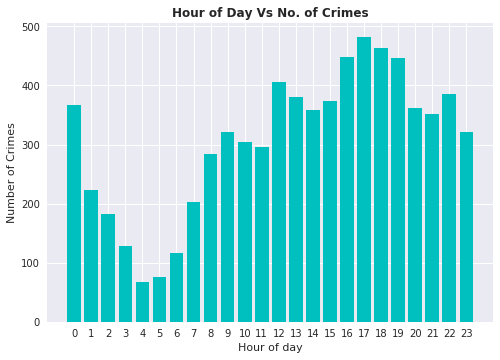

In [67]:
plt.bar(groupsHour.index, groupsHour.X, width=0.8,color='c',align='center')

plt.title("Hour of Day Vs No. of Crimes", fontweight='bold')
plt.xlabel("Hour of day")
plt.ylabel("Number of Crimes")
plt.grid(True)
tick_val = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(tick_val)
plt.show()

We see a lot of crimes happening during the late afternoon and the beginning of the evening (16h - 19h). For our further analysis we sort the data by date and time in an ascending way.

In [68]:
crimetimes = crime.sort_values(by='Time', ascending=True)
crimedates = crimetimes.sort_values(by='Date', ascending=True)
datesorted = crimedates.reset_index()
del datesorted['index']
datesorted.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Hour,Weeknumber
0,21680269,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Wednesday,2003-01-01,1900-01-01 22:10:00,BAYVIEW,NONE,SELBY ST / PALOU AV,-122.400248,37.739277,"(37.7392774132044, -122.400247774249)",2168026964070,22,"(2003, 1, 3)"
1,30001749,OTHER OFFENSES,OBSCENE PHONE CALLS(S),Wednesday,2003-01-01,1900-01-01 08:30:00,MISSION,NONE,900 Block of TREAT AV,-122.413147,37.754954,"(37.7549540482182, -122.413147019892)",3000174919050,8,"(2003, 1, 3)"
2,30014770,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Friday,2003-01-03,1900-01-01 20:00:00,SOUTHERN,NONE,MCCOPPIN ST / VALENCIA ST,-122.422526,37.771596,"(37.7715962069149, -122.42252632893)",3001477028160,20,"(2003, 1, 5)"
3,30025084,VEHICLE THEFT,STOLEN TRUCK,Tuesday,2003-01-07,1900-01-01 02:30:00,BAYVIEW,NONE,100 Block of OLMSTEAD ST,-122.403120,37.722498,"(37.7224976982068, -122.403120225649)",3002508407025,2,"(2003, 2, 2)"
4,30029105,DRUG/NARCOTIC,POSSESSION OF BASE/ROCK COCAINE,Wednesday,2003-01-08,1900-01-01 04:22:00,TENDERLOIN,"ARREST, BOOKED",JONES ST / ELLIS ST,-122.412784,37.784866,"(37.7848656939297, -122.412784096509)",3002910516621,4,"(2003, 2, 3)"


In [69]:
#we check whether there are indeed 7 unique days (i.e. no typos)
datesorted['DayOfWeek'].unique().tolist() 

['Wednesday', 'Friday', 'Tuesday', 'Thursday', 'Saturday', 'Monday', 'Sunday']

# Data Visualization

In [70]:
#we check the amount of crimes occurred per day
datav = crime
datav['DayOfWeek'].value_counts()

Friday       1138
Wednesday    1057
Saturday     1048
Tuesday      1045
Thursday     1043
Monday       1032
Sunday        985
Name: DayOfWeek, dtype: int64

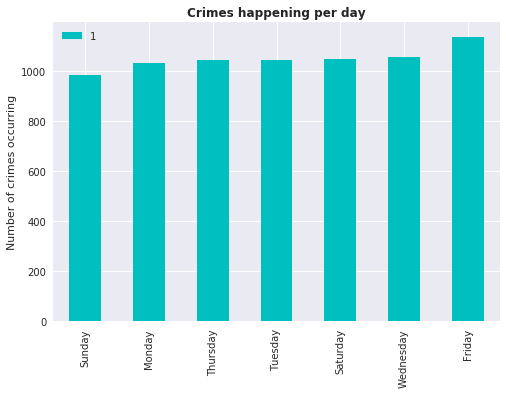

In [71]:
D = {"Monday":1032, "Tuesday":1045, "Wednesday":1057, "Thursday":1043, "Friday":1138, "Saturday":1048, "Sunday":985}
Dsort = [(k, D[k]) for k in sorted(D, key=D.get, reverse=False)]
s2 = pd.DataFrame(Dsort)
s3 = s2.plot.bar(color='c', align='center')
plt.ylabel('Number of crimes occurring')
plt.title('Crimes happening per day', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6], ['Sunday','Monday','Thursday','Tuesday','Saturday','Wednesday','Friday'])
plt.grid(True)
plt.show()

Amount of crimes on the different days of the week are ordered from low to high. We see a little spike of the amount of crimes happening on Friday. Crime occurring on other days of the week are roughly equally likely. <br>To see whether the type of crime or the hour of occurrence is different on different days, we will make a stacked bar graph for categories and timeslots. Since there are 37 categories, including them all in a bar graph would get quite messy. Therefore we decided to investigate a few categories we think are interesting from the perspective of deploying specialized police officers. When selecting these categories we also kept in mind that we needed enough observations in that category to be able to see them clearly in the stacked bar graph. The categories we selected are Vehicle Theft, Sex Offenses (both forcible and non forcible), Drug/Narcotic, Missing Person and Assault. For the timeslots we chose to make 8 slots of 3 hours.

### Crimes per day, categorized

In [72]:
catVT = datav[(datav['Category'] == "VEHICLE THEFT")]

catSO = datav[(datav['Category'] == "SEX OFFENSES, FORCIBLE")|(datav['Category'] == "SEX OFFENSES, NON FORCIBLE")]
catDN = datav[(datav['Category'] == "DRUG/NARCOTIC")]
catMP = datav[(datav['Category'] == "MISSING PERSON")]
catAS = datav[(datav['Category'] == "ASSAULT")]

catOTHER = datav[(datav['Category'] != "VEHICLE THEFT")&(datav['Category'] != "SEX OFFENSES, FORCIBLE")\
                 &(datav['Category'] != "SEX OFFENSES, NON FORCIBLE")&(datav['Category'] != "DRUG/NARCOTIC")\
                 &(datav['Category'] != "MISSING PERSON")&(datav['Category'] != "ASSAULT")]

In [73]:
#count values for 'DayOfWeek' just like before, but now by category
catVT['DayOfWeek'].value_counts()

Friday       96
Saturday     80
Tuesday      68
Wednesday    62
Monday       61
Sunday       60
Thursday     55
Name: DayOfWeek, dtype: int64

In [74]:
catSO['DayOfWeek'].value_counts()

Friday       10
Tuesday       9
Sunday        8
Saturday      5
Thursday      4
Monday        3
Wednesday     3
Name: DayOfWeek, dtype: int64

In [75]:
catDN['DayOfWeek'].value_counts()

Tuesday      77
Wednesday    75
Thursday     61
Friday       60
Saturday     55
Monday       51
Sunday       49
Name: DayOfWeek, dtype: int64

In [76]:
catMP['DayOfWeek'].value_counts()

Tuesday      39
Thursday     36
Friday       35
Wednesday    32
Monday       31
Sunday       28
Saturday     27
Name: DayOfWeek, dtype: int64

In [77]:
catAS['DayOfWeek'].value_counts()

Friday       109
Thursday     104
Sunday       102
Saturday      98
Wednesday     95
Monday        92
Tuesday       78
Name: DayOfWeek, dtype: int64

In [78]:
catOTHER['DayOfWeek'].value_counts()

Friday       828
Monday       794
Wednesday    790
Thursday     783
Saturday     783
Tuesday      774
Sunday       738
Name: DayOfWeek, dtype: int64

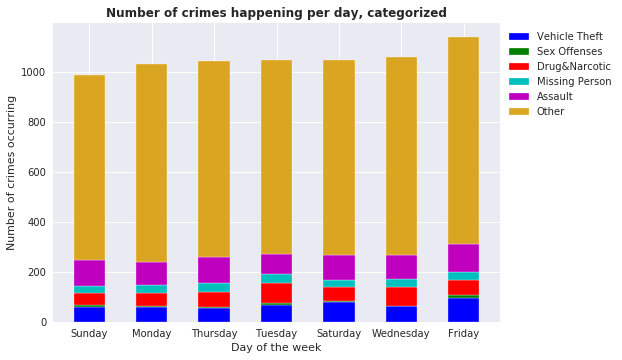

In [79]:
#stacked bar graph, using same order of plot as above

#values of the groups
VEHICLETHEFT = [60, 61, 55, 68, 80, 62, 96]
SEXOFFENSES = [8, 3, 4, 9, 5, 3, 10]
DRUGNARCOTIC = [49, 51, 61, 77, 55, 75, 60]
MISSINGPERSON = [28, 31, 36, 39, 27, 32, 35]
ASSAULT = [102, 92, 104, 78, 98, 95, 109]
OTHER = [738, 794, 783, 774, 783, 790, 828]

#height of the bars
VTSO = np.add(VEHICLETHEFT,SEXOFFENSES)
VTSODN = np.add(VTSO,DRUGNARCOTIC)
VTSODNMP = np.add(VTSODN,MISSINGPERSON)
VTSODNMPAS = np.add(VTSODNMP,ASSAULT)

#position of the bars on the x-axis
r = [0,1,2,3,4,5,6]

#names of groups and barwidth
days = ['Sunday', 'Monday', 'Thursday', 'Tuesday', 'Saturday', 'Wednesday', 'Friday']
barWidth = 0.5

#plotting bars
plt.bar(r, VEHICLETHEFT, color='b', edgecolor='white', width=barWidth, label='Vehicle Theft')
plt.bar(r, SEXOFFENSES, bottom=VEHICLETHEFT, color='g', edgecolor='white', width=barWidth, label='Sex Offenses')
plt.bar(r, DRUGNARCOTIC, bottom=VTSO, color='r', edgecolor='white', width=barWidth, label='Drug&Narcotic')
plt.bar(r, MISSINGPERSON, bottom=VTSODN, color='c', edgecolor='white', width=barWidth, label='Missing Person')
plt.bar(r, ASSAULT, bottom=VTSODNMP, color='m', edgecolor='white', width=barWidth, label='Assault')
plt.bar(r, OTHER, bottom=VTSODNMPAS, color='#daa520', edgecolor='white', width=barWidth, label='Other')
#format
plt.xticks(r, days, rotation=0)
plt.xlabel("Day of the week")
plt.ylabel("Number of crimes occurring")
plt.title("Number of crimes happening per day, categorized", fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid(True)
plt.show()

As we can see from the graph, there don't seem to be large differences in the amount of crimes committed of a specific type across days of the week.

### Crimes per day, timeslot separated

The timeslots we will be using are the following:<br>
 - time1: 1 till 3 a.m. 
 - time2: 4 till 6 a.m.
 - time3: 7 till 9 a.m.
 - time4: 10 till 12 a.m.
 - time5: 13 till 15 p.m.
 - time6: 16 till 18 p.m.
 - time7: 19 till 21 p.m.
 - time8: 22 till 24 p.m.
<br><br>
We use the variable 'Hour' we created, which takes the values {0,1,2,...,23} in the dataset, 0 being midnight.

In [80]:
time1 = datav[(datav['Hour'] == 1) | (datav['Hour'] == 2) | (datav['Hour'] == 3)]
time2 = datav[(datav['Hour'] == 4) | (datav['Hour'] == 5) | (datav['Hour'] == 6)]
time3 = datav[(datav['Hour'] == 7) | (datav['Hour'] == 8) | (datav['Hour'] == 9)]
time4 = datav[(datav['Hour'] == 10) | (datav['Hour'] == 11) | (datav['Hour'] == 12)]
time5 = datav[(datav['Hour'] == 13) | (datav['Hour'] == 14) | (datav['Hour'] == 15)]
time6 = datav[(datav['Hour'] == 16) | (datav['Hour'] == 17) | (datav['Hour'] == 18)]
time7 = datav[(datav['Hour'] == 19) | (datav['Hour'] == 20) | (datav['Hour'] == 21)]
time8 = datav[(datav['Hour'] == 22) | (datav['Hour'] == 23) | (datav['Hour'] == 0)]

In [81]:
#count values for 'DayOfWeek' just like before, but now by category
time1['DayOfWeek'].value_counts()

Saturday     124
Sunday       110
Friday        66
Tuesday       63
Thursday      62
Monday        55
Wednesday     54
Name: DayOfWeek, dtype: int64

In [82]:
time2['DayOfWeek'].value_counts()

Friday       44
Thursday     41
Monday       39
Tuesday      36
Saturday     34
Sunday       34
Wednesday    32
Name: DayOfWeek, dtype: int64

In [83]:
time3['DayOfWeek'].value_counts()

Tuesday      139
Thursday     129
Friday       127
Wednesday    127
Monday       124
Saturday      90
Sunday        72
Name: DayOfWeek, dtype: int64

In [84]:
time4['DayOfWeek'].value_counts()

Friday       158
Wednesday    151
Tuesday      148
Thursday     144
Saturday     143
Monday       142
Sunday       121
Name: DayOfWeek, dtype: int64

In [85]:
time5['DayOfWeek'].value_counts()

Friday       175
Thursday     166
Monday       164
Wednesday    156
Tuesday      152
Saturday     151
Sunday       149
Name: DayOfWeek, dtype: int64

In [86]:
time6['DayOfWeek'].value_counts()

Friday       237
Thursday     212
Wednesday    203
Tuesday      194
Monday       194
Sunday       184
Saturday     169
Name: DayOfWeek, dtype: int64

In [87]:
time7['DayOfWeek'].value_counts()

Wednesday    186
Tuesday      178
Friday       171
Monday       170
Thursday     156
Sunday       155
Saturday     144
Name: DayOfWeek, dtype: int64

In [88]:
time8['DayOfWeek'].value_counts()

Saturday     193
Friday       160
Sunday       160
Wednesday    148
Monday       144
Tuesday      135
Thursday     133
Name: DayOfWeek, dtype: int64

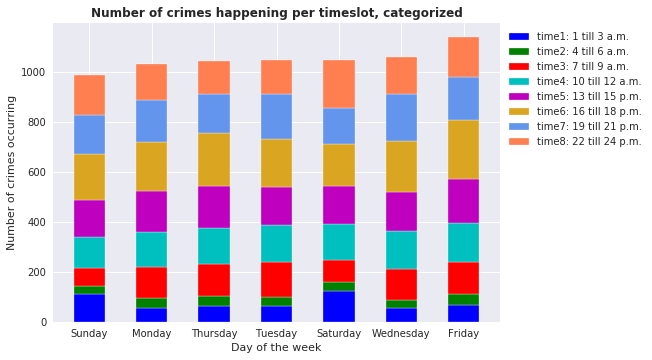

In [89]:
#stacked bar graph, using same order of plot as above

#values of the groups
time1 = [110, 55, 62, 63, 124, 54, 66]
time2 = [34, 39, 41, 36, 34, 32, 44]
time3 = [72, 124, 129, 139, 90, 127, 127]
time4 = [121, 142, 144, 148, 143, 151, 158]
time5 = [149, 164, 166, 152, 151, 156, 175]
time6 = [184, 194, 212, 194, 169, 203, 237]
time7 = [155, 170, 156, 178, 144, 186, 171]
time8 = [160, 144, 133, 135, 193, 148, 160]

#height of the bars
T12 = np.add(time1,time2)
T123 = np.add(T12,time3)
T1234 = np.add(T123,time4)
T12345 = np.add(T1234,time5)
T123456 = np.add(T12345, time6)
T1234567 = np.add(T123456, time7)
T12345678 = np.add(T1234567, time8)

#position of the bars on the x-axis
r = [0,1,2,3,4,5,6]

#names of groups and barwidth
days = ['Sunday', 'Monday', 'Thursday', 'Tuesday', 'Saturday', 'Wednesday', 'Friday']
barWidth = 0.5

#plotting bars
plt.bar(r, time1, color='b', edgecolor='white', width=barWidth, label='time1: 1 till 3 a.m.')
plt.bar(r, time2, bottom=time1, color='g', edgecolor='white', width=barWidth, label='time2: 4 till 6 a.m.')
plt.bar(r, time3, bottom=T12, color='r', edgecolor='white', width=barWidth, label='time3: 7 till 9 a.m.')
plt.bar(r, time4, bottom=T123, color='c', edgecolor='white', width=barWidth, label='time4: 10 till 12 a.m.')
plt.bar(r, time5, bottom=T1234, color='m', edgecolor='white', width=barWidth, label='time5: 13 till 15 p.m.')
plt.bar(r, time6, bottom=T12345, color='#DAA520', edgecolor='white', width=barWidth, label='time6: 16 till 18 p.m.')
plt.bar(r, time7, bottom=T123456, color='#6495ED', edgecolor='white', width=barWidth, label='time7: 19 till 21 p.m.')
plt.bar(r, time8, bottom=T1234567, color='#FF7F50', edgecolor='white', width=barWidth, label='time8: 22 till 24 p.m.')

#format
plt.xticks(r, days, rotation=0)
plt.xlabel("Day of the week")
plt.ylabel("Number of crimes occurring")
plt.title("Number of crimes happening per timeslot, categorized", fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid(True)
plt.show()

As we can see from the graph, there don't seem to be large differences in the amount of crimes committed in a certain timeslot across different days of the week. Only for the weekend we can see that in the timeslots between 22 p.m. and 3 a.m. there are more crimes committed, compared to the other days of the week (see the coral and blue bars that seem a little bigger). On the other hand, the early morning figures for Saturday and Sunday seem a little smaller than the rest of the week (red bar). However these differences don't seem to be very extreme.

# K-Means Clustering

To find a correlation between the location of the crime and the hour/day of occurrence and/or the type of the crime we will be using k-means clustering. After specifying the number of clusters, the k-means algorithm will assign every observation to one of the clusters. In doing so it assigns every datapoint as such that it is closer to it's own cluster center than to any of the other cluster centers. The cluster center is defined as the arithmetic mean of all the points belonging to the cluster. The goal of the algorithm is to minimize the distances between the datapoints and the cluster centers. This is similar to the way Ordinary Least Squares regression minimizes the squared distances from the datapoints to the regression line.

The simplest form of the algorithm basically consists of 4 steps:<br>
1. k "means" are randomly generated, k being the amount of clusters you specified upfront. These "means" aren't actually means, but they just serve as a starting point for the algorithm, as initial cluster centers.
2. every datapoint is assigned to the closest "mean", this way we obtain k clusters of datapoints. However this division of clusters is not yet optimal.
3. The geometric center of the clusters created in step 2 is the new "mean" or cluster center.
4. Use the new cluster center defined in step 3 to redo step 2. As steps 2 and 3 are repeated, the resulting clusters are improved.

There are two problems with the k-means approach.<br> The first is that even though the algorithm improves the result with every iteration, it doesn't necessarily converge to the global optimum. In fact the result may be affected by the initial guess made in step 1. This is why most implementations of the k-means model make sure that the algorithm runs several times with different starting guesses. This is also the case for the k-means function that we will be using later on.<br>
Another drawback is that one has to specify the amount of clusters by hand. For some datasets it might be enough to make a scatterplot and one immediately sees that there should be for example 4 clusters, like in this picture.

In [90]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='initial scatter.png'></td><td><img src='4clusters example.png'></td></tr></table>"))

,


But what if it is not clear at first glance? The algorithm will find as many clusters as you request, regardless of whether it makes sense to find that many, it doesn't learn the optimal number of clusters from the dataset. As we can see here, the algorithm finds 6 clusters when asked, but intuitively we can see that 6 is not the optimal amount of clusters here. A more formal way of finding the optimal amount of clusters is by using an Elbow plot, which we will do later on.

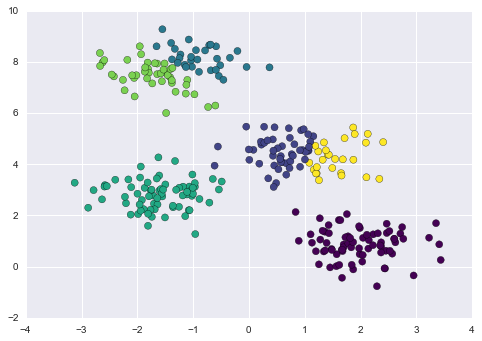

In [91]:
from IPython.display import Image
Image("6clustersexample.png")

First we check for any missing values or outliers in our dataset that might lead to odd results when clustering.

In [92]:
print(crime.isna().sum())

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
Hour          0
Weeknumber    0
dtype: int64


Each row contains an crime incident and each observation contains coordinates. We create a scatter plot of our data to detect the possible outliers.

In [93]:
kcrime = datesorted 

We drop te variables we don't need. 

In [94]:
kcrime.drop(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 
                'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'Location', 'PdId', 'Hour', 'Weeknumber'],
                axis=1, inplace=True)

In [95]:
kcrime.head()

,X,Y
0,-122.400248,37.739277
1,-122.413147,37.754954
2,-122.422526,37.771596
3,-122.403120,37.722498
4,-122.412784,37.784866


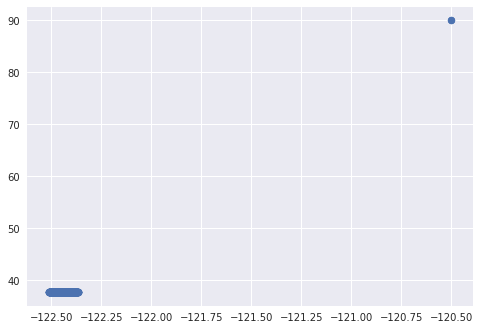

In [96]:
plt.scatter(kcrime.iloc[:,0], kcrime.iloc[:,1])
plt.show()

We see that there are some outliers. We want to investigate whether there are multiple outliers or only a few.  

In [97]:
kcrime[kcrime['X'] >= -121].count()  

X    2
Y    2
dtype: int64

We have only 2 outliers. For the sake of our analysis, we will drop them, using the command below. As expected, our file now consists of 7346 observations, whereas before it was 7348 observations. We know we can safely drop them because the reported coordinates for these two outliers are not even inside the jurisdiction of san francisco police enforcement (note that 2 degrees longitude is quite a lot in distance). For these two observations the coordinates were either recorded wrongly, or they were some special case of interjurisdictional crimefighting. Dropping them will therefore not be likely to bias our results.

In [116]:
kcrime1 = kcrime[kcrime['X'] <= -121]  #Only selecting the datapoints without the outliers
                                       # (i.e. excluding X coordinates smaller than -121)

In [117]:
kcrime1.describe()

,X,Y
count,7346.000000,7346.000000
mean,-122.422877,37.767581
std,0.025491,0.024070
min,-122.513642,37.708031
25%,-122.432915,37.753632
50%,-122.416226,37.775421
75%,-122.406959,37.784401
max,-122.364937,37.819923


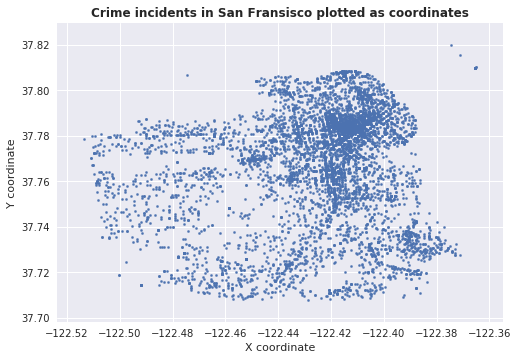

In [100]:
plt.scatter(kcrime1.iloc[:,0], kcrime1.iloc[:,1], s=5)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Crime incidents in San Fransisco plotted as coordinates', fontweight='bold')
plt.show()

This looks a lot nicer to start our k-means analysis. First we have to determine the optimal amount of clusters using the elbow plot. To create the elbow plot, we run the k-means clustering method for a range of values of k, in this case 1 to 15. For every value of k we calculate the sum of squared errors (distance from datapoints to cluster center squared). Now if we plot the number of clusters on the x axis and the SSE on the y axis, we can see that for low values of k, an additional cluster has huge benefits for reducing SSE, but for higher values of k this benefit diminishes. The idea of the elbow plot is that you can find the optimal amount of clusters at the point where the graph 'bends', from vertical to horizontal like an elbow. This method is a little subjective, and sometimes it can be hard to identify a bending point, but this is an easy and effective way of approaching the optimum. There are several more difficult methods but we will not delve into those here. In our elbow plot, the part between 4, 5 and 6 clusters is almost linear, while still yielding a significant benefit in reducing SSE. We therefore assume that the bend is at 5 clusters, since we think 3 or 4 is too few and 6 might be already too much.

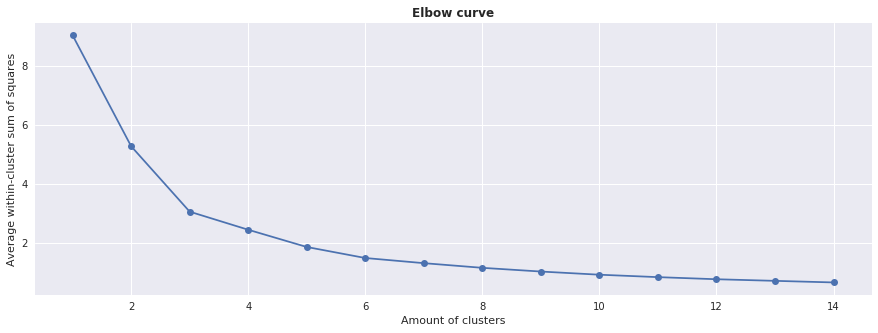

In [101]:
X = kcrime1
distortions = []
rangeq = range(1,15)
for k in rangeq:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(rangeq, distortions, marker='o')
plt.grid(True)
plt.title('Elbow curve', fontweight='bold')
plt.xlabel('Amount of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.show()

In [102]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(kcrime1)
centers = kmeans.cluster_centers_
y_kmeans = kmeans.predict(kcrime1) #storing the clusters

In [103]:
plt.scatter(kcrime1.iloc[:,0], kcrime1.iloc[:,1], c=y_kmeans, s=5, cmap='viridis') #printing the centers
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5) #printing centers
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Crime incidents in San Fransisco plotted as coordinates, clustered in 5 quadrants', fontweight='bold')
plt.savefig('5 clusters.png', bbox_inches='tight')
plt.close()

In [104]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='5 clusters.png'></td><td><img src='map san francisco.png'></td></tr></table>"))

,


We can immediately see that crime is more concentrated in the Northeastern part of San Francisco, the city centre which is not really surprising. Next we investigate wheter we can find some correlation between location and the type of crime, hour of occurrence and day of the week.

# Second part of the analysis, visualizing correlation between location and variable X through clustering

In the previous chapter we clustered the crime incidents based on location using GPS coordinates. In this chapter, we will extend our analysis by investigating whether correlation between location and other relevant variables exists. If it is to happen that there indeed exist patterns between categorical variables and location, we still have no basis to infer any causal relationship. However, it might be useful to devote police resources to particular regions of San Francisco in a more efficient manner. We can illustrate this with an example. Assume that in North-East San Francisco a lot of drug deals take place and only very few burglaries and assume that in North-West exactly the opposite happens (i.e. lots of burglaries, very few drug deals), then police departments know what to focus on and will eventually be capable of tracing criminals more easily. This is called predictive policing, as has been discussed in the introduction. In other words, based on past information how should we deploy our resources so that we optimize our returns in terms of criminals caught per unit spent on policing. 

In this chapter it is investigated whether there exists a relationship between location and :
* Type of crime
* Time
* Day of the Week

For different types of crime, we zoom in on assaults, vehicle thefts, incidents that have to do with drugs, persons that were reported as missing and sex offenses. As a benchmark for the analysis of these categories we also include all of the rest of categories. For time we split up in eight groups of three hours each (i.e. group 1 consists of all incidents that happened at 1am, 2am and 3am, group 2 consists of all incidents that happened at 4am, 5am and 6am etc.). The analysis using different days of the week, we created 7 groups, where each group obviously contained one day of the week.  

# Correlation between location and type of crime

Below we sort by different types of crime, namely vehicle thefts, Sex Offenses, Drug/narcotic incidents, missing person incidents and assaults. The rest of the incidents are grouped together and labelled as the "rest". By printing the lenght of the dataframes, we see the composition of the different categories.

In [105]:
crimeq = crime[crime['X'] <= -121]  
print("The whole sample without subsetting any categories consists of", str(len(crimeq)), "observations")
sub_crime_assault = crimeq[(crimeq['Category'] == "ASSAULT")] #look at just Assaults
sub_crime_vehicle = crimeq[(crimeq['Category'] == "VEHICLE THEFT")] #look at just Vehicle Theft
sub_crime_drug = crimeq[(crimeq['Category'] == "DRUG/NARCOTIC")] #look at just Drug/Narcotic incidents
sub_crime_missing = crimeq[(crimeq['Category'] == "MISSING PERSON")] #look at just incidents linked to a missing person

sub_crime_sex1 = crimeq[(crimeq['Category'] == 'SEX OFFENSES, FORCIBLE')] 
sub_crime_sex2 = crimeq[(crimeq['Category'] == 'SEX OFFENSES, NON FORCIBLE')]
frames = [sub_crime_sex1, sub_crime_sex2]
sub_crime_sex = pd.concat(frames)

sub_crime_rest = crimeq[(crimeq['Category'] != "MISSING PERSON") & (crimeq['Category'] != "ASSAULT")\
                        & (crimeq['Category'] != "VEHICLE THEFT")\
                        & (crimeq['Category'] != "DRUG/NARCOTIC")\
                        & (crimeq['Category'] != "SEX OFFENSES, FORCIBLE")\
                        & (crimeq['Category'] != "SEX OFFENSES, NON FORCIBLE")] 
#look at just incidents linked to the rest of the categories

length1 = len(sub_crime_assault)+ (len(sub_crime_vehicle)+len(sub_crime_drug)+len(sub_crime_missing)+len(sub_crime_sex))
print("When we sum the lenghts of all the subcategories, we end up with" + " " + str(length1) + " " + "observations.")
print("We have" + " " + str(len(sub_crime_rest)) + " observations of the whole dataframe excluding\
 the subcategories above. Summing those two groups, we get the length of the whole dataframe.")

The whole sample without subsetting any categories consists of 7346 observations
When we sum the lenghts of all the subcategories, we end up with 1857 observations.
We have 5489 observations of the whole dataframe excluding the subcategories above. Summing those two groups, we get the length of the whole dataframe.


In [106]:
#Here we sort by the different groups and coordinates, so that we end up with dataframes only including -->
#the GPS coordinates belonging to the crime incidents of each category. 
coordinates = ['X', 'Y']
sub_crime_assault_X = sub_crime_assault[coordinates]
sub_crime_vehicle_X = sub_crime_vehicle[coordinates]
sub_crime_drug_X = sub_crime_drug[coordinates]
sub_crime_missing_X = sub_crime_missing[coordinates]
sub_crime_sex_X = sub_crime_sex[coordinates]
sub_crime_rest_X = sub_crime_rest[coordinates]

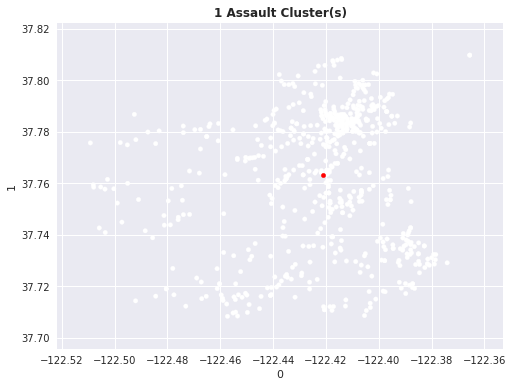

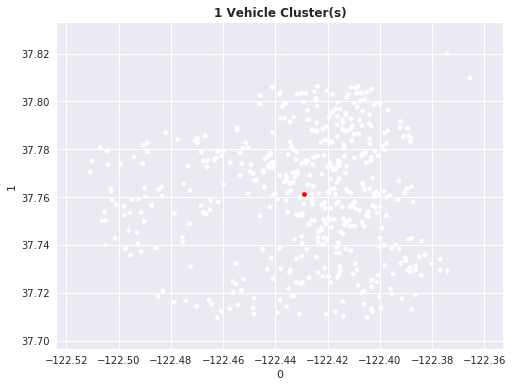

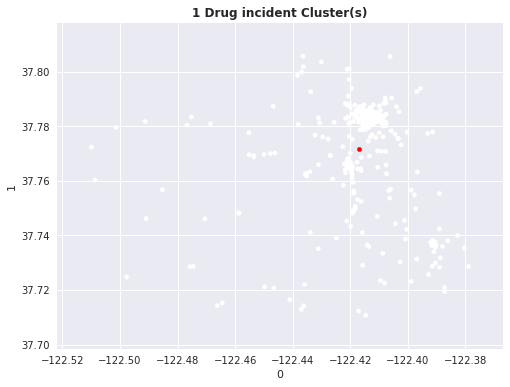

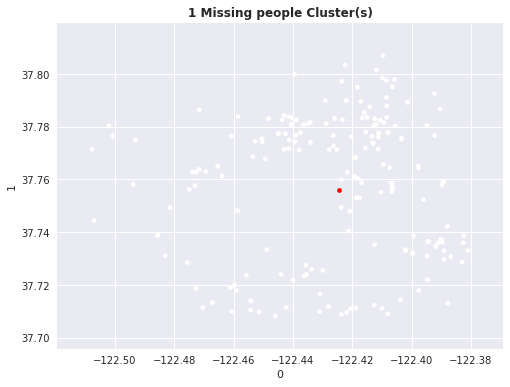

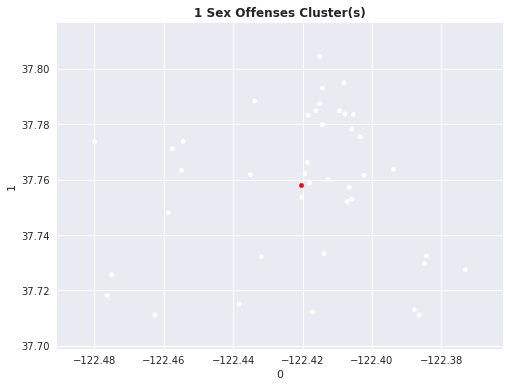

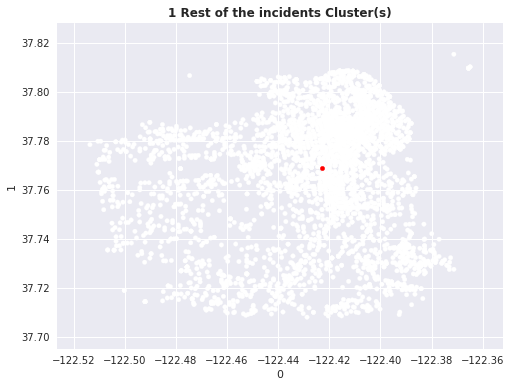

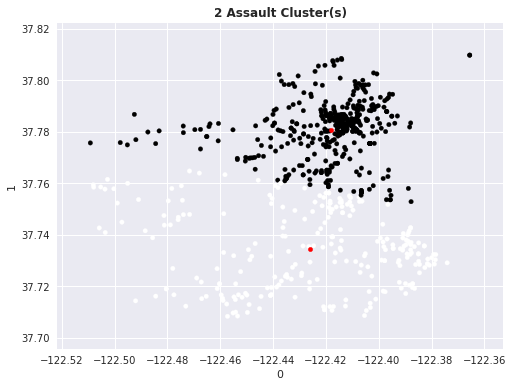

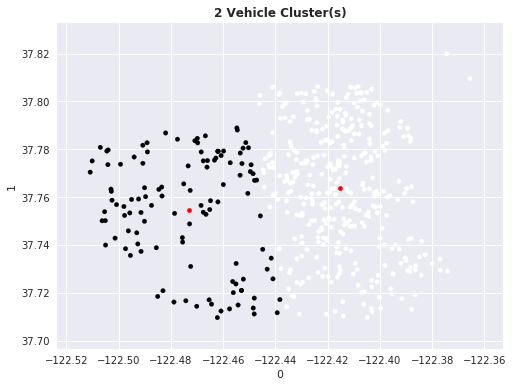

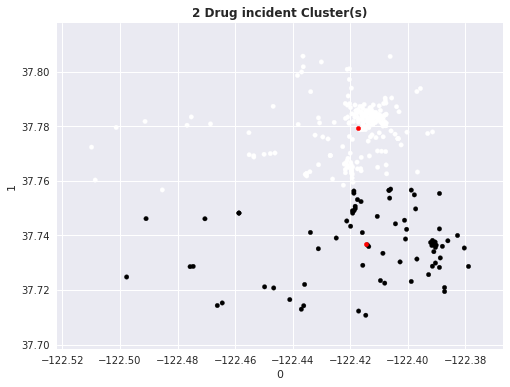

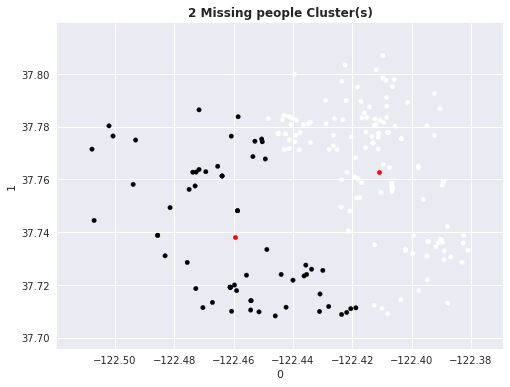

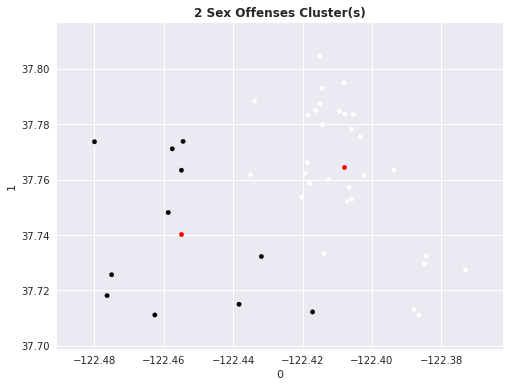

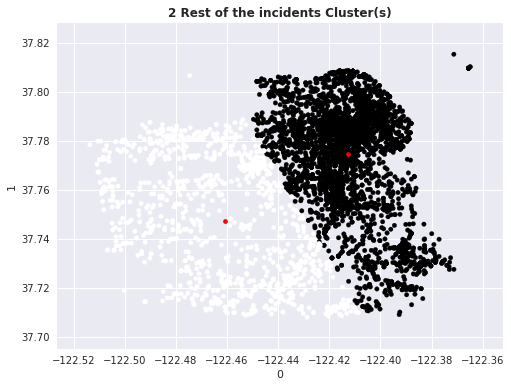

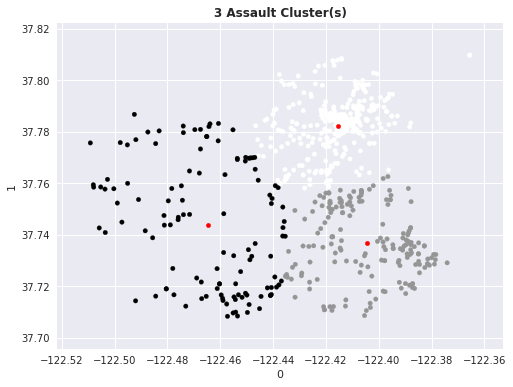

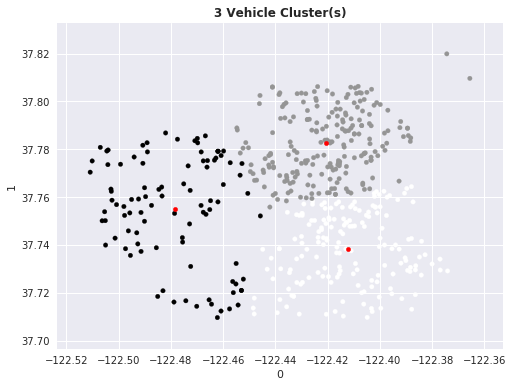

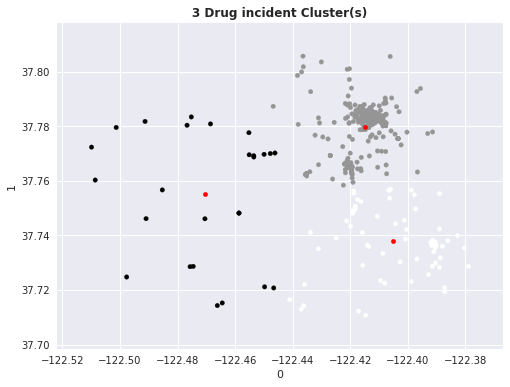

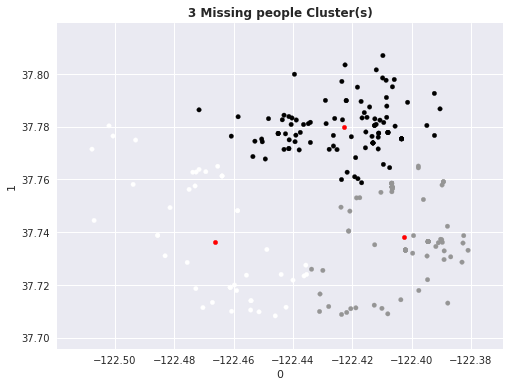

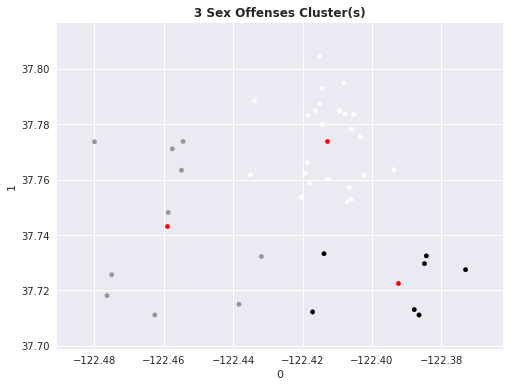

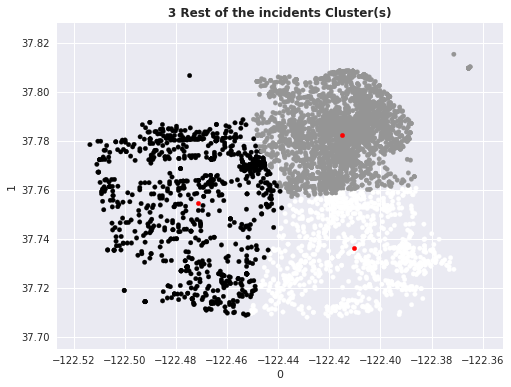

In [107]:
for n_clusters in range(1,4,1):      #The for loop allows us to plot multiple clusters per category. 
    kmassault = KMeans(n_clusters)   #Specify that we are going to perform a K-means analysis with an x amount of clusters. 
    kmvehicle = KMeans(n_clusters)   #The specification is stored in kmassault, kmvehicle etc.
    kmdrug = KMeans(n_clusters)
    kmmissing = KMeans(n_clusters)
    kmsex = KMeans(n_clusters)
    kmrest = KMeans(n_clusters)
      
    kmassault.fit(sub_crime_assault_X) #Fitting the clusters using GPS coordinates of each category. 
    kmvehicle.fit(sub_crime_vehicle_X) #The amount of clusters is specified in the for loop. 
    kmdrug.fit(sub_crime_drug_X)
    kmmissing.fit(sub_crime_missing_X)
    kmsex.fit(sub_crime_sex_X)
    kmrest.fit(sub_crime_rest_X)

    y_kmassault = kmassault.predict(sub_crime_assault_X) #Storing the clusters, which will be used to visualize the clusters. 
    y_kmvehicle = kmvehicle.predict(sub_crime_vehicle_X)
    y_kmdrug = kmdrug.predict(sub_crime_drug_X)
    y_kmmissing = kmmissing.predict(sub_crime_missing_X)
    y_kmsex = kmsex.predict(sub_crime_sex_X)
    y_kmrest = kmrest.predict(sub_crime_rest_X)

    centersassault = kmassault.cluster_centers_ #Storing the centers of the clusters of each category
    centersvehicle = kmvehicle.cluster_centers_
    centersdrug = kmdrug.cluster_centers_
    centersmissing = kmmissing.cluster_centers_
    centerssex = kmsex.cluster_centers_
    centersrest = kmrest.cluster_centers_
   
    #For each category, we create separate scatter plots for each category and its accompanying center(s). 
    axa = sub_crime_assault_X.plot(kind='scatter',x='X',y='Y', legend=str(n_clusters), c=y_kmassault, figsize=(8, 6))
    pd.DataFrame(centersassault).plot(kind='scatter',x=0,y=1,color='r',ax=axa)
    axa.set_title(str(n_clusters) + " Assault Cluster(s)", fontweight='bold')
    
    axv = sub_crime_vehicle_X.plot(kind='scatter',x='X',y='Y', legend=str(n_clusters), c=y_kmvehicle, figsize=(8, 6))
    pd.DataFrame(centersvehicle).plot(kind='scatter',x=0,y=1,color='r',ax=axv)
    axv.set_title(str(n_clusters) + " Vehicle Cluster(s)", fontweight='bold')
    
    axd = sub_crime_drug_X.plot(kind='scatter',x='X',y='Y', legend=str(n_clusters), c=y_kmdrug, figsize=(8, 6))
    pd.DataFrame(centersdrug).plot(kind='scatter',x=0,y=1,color='r',ax=axd)
    axd.set_title(str(n_clusters) + " Drug incident Cluster(s)", fontweight='bold')
    
    axm = sub_crime_missing_X.plot(kind='scatter',x='X',y='Y', legend=str(n_clusters), c=y_kmmissing, figsize=(8, 6))
    pd.DataFrame(centersmissing).plot(kind='scatter',x=0,y=1,color='r',ax=axm)
    axm.set_title(str(n_clusters) + " Missing people Cluster(s)", fontweight='bold')
    
    axs = sub_crime_sex_X.plot(kind='scatter',x='X',y='Y', legend=str(n_clusters), c=y_kmsex, figsize=(8, 6))
    pd.DataFrame(centerssex).plot(kind='scatter',x=0,y=1,color='r',ax=axs)
    axs.set_title(str(n_clusters) + " Sex Offenses Cluster(s)", fontweight='bold')
    
    axr = sub_crime_rest_X.plot(kind='scatter',x='X',y='Y', legend=str(n_clusters), c=y_kmrest, figsize=(8, 6))
    pd.DataFrame(centersrest).plot(kind='scatter',x=0,y=1,color='r',ax=axr)
    axr.set_title(str(n_clusters) + " Rest of the incidents Cluster(s)", fontweight='bold')

We realize that creating seperate scatter plots is not the best way to visualize potential differences in locations of crime between different categories.  

Below we plot the centers of the clusters of the different categories together in one graph. We do this for 1, 2 and 3 clusters per category. Each cluster(group) belonging to a specific category has its own color. By putting all the clusters in one graph, it is easier to visualize whether there are in fact significant differences in locations between different types of crime.

We had to do the kmeans clustering process again, as the num_clusters equals 3 as a default position. This is the result of evaluating the previous cell. 

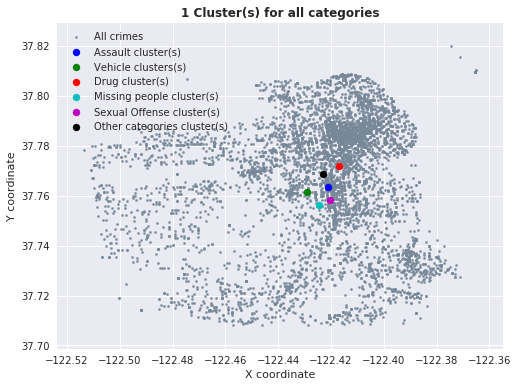

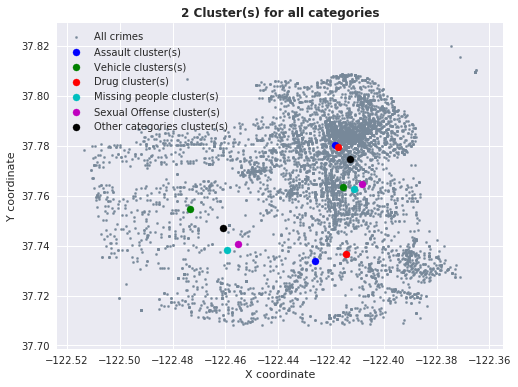

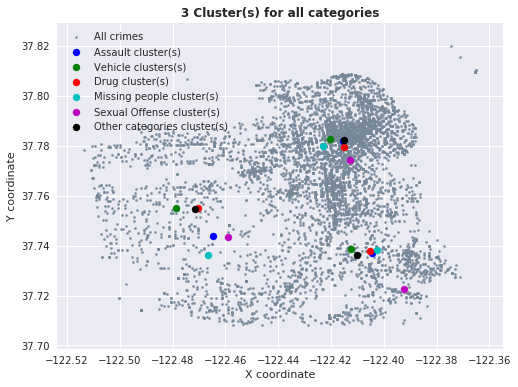

In [108]:
for num_clusters in range(1,4,1):
    kmassaultt = KMeans(num_clusters)
    kmvehiclet = KMeans(num_clusters)
    kmdrugt = KMeans(num_clusters)
    kmmissingt = KMeans(num_clusters)
    kmsext = KMeans(num_clusters)
    kmrestt = KMeans(num_clusters)

    kmassault_fit = kmassaultt.fit(sub_crime_assault_X)
    kmvehicle_fit = kmvehiclet.fit(sub_crime_vehicle_X)
    kmdrug_fit = kmdrugt.fit(sub_crime_drug_X)
    kmmissing_fit = kmmissingt.fit(sub_crime_missing_X)
    kmssex_fit = kmsext.fit(sub_crime_sex_X)
    kmrest_fit = kmrestt.fit(sub_crime_rest_X)
    
    together = kcrime1.plot(kind='scatter',x='X',y='Y', c='lightslategray', s=5, figsize=(8, 6))
    pd.DataFrame(kmassault_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='b',ax=together, s=50)
    pd.DataFrame(kmvehicle_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='g',ax=together, s=50)
    pd.DataFrame(kmdrug_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='r',ax=together,s=50)
    pd.DataFrame(kmmissing_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='c',ax=together, s=50)
    pd.DataFrame(kmssex_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='m',ax=together, s=50)
    pd.DataFrame(kmrest_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='k',ax=together, s=50)
 
    together.set_title(str(num_clusters) + " Cluster(s) for all categories", fontweight='bold')
    together.legend(["All crimes", "Assault cluster(s)", "Vehicle clusters(s)", "Drug cluster(s)", "Missing people cluster(s)\
    ", "Sexual Offense cluster(s)", "Other categories cluster(s)"])
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

**Conclusion**<br>
By looking at the three graphs above, we were unable to identify any hotspots for specific categories on the map. When allowing for 1 cluster, the clustercenters of the 6 categories are all located very closely together. When allowing for 2 clusters, the distribution becomes a little bite more widespread. For instance, the clusters of categories "Drugs" and "Assault" (resp. red and blue) have a different position on the map when comparing it to the rest of the categories. However, this still doesn't tell us about the amount of datapoints around those at a different location. It may well be that in this case the determination of the location of the Assault and Drugs cluster (when allowing 2 for clusters) were driven by only a few crime incidents in that region. If that is the case, this cluster doesn't offer police departments a lot of information, because it is still optimal to focus in the city center, as in that region still most of the crimes of the category happen. Only if cluster x when allowing for 1 cluster, differed from the position of the other ones we could state something useful about the location where to focus for this type of crime. This is because when allowing for 1 cluster, the cluster includes the weighted average of all coordinates of this crime category. If the location differed significantly, we also know something about the magnitude and the intensity of the incidents around this cluster. When we allow for three clusters, again the clusters become aligned and move towards a similar position. Based on the graphs above, we cannot say a lot of valuable things regarding the relation between types of crime and location of these crimes. 


# Correlation between location and clustered time frames

In the next part, we extend our analysis by trying to find a correlation between location and the time of the day of crimes happening. We created 8 different groups, each covering 3 hours of the day.

In [120]:
time1 = crimeq[(crimeq['Hour'] == 1) | (crimeq['Hour'] == 2) | (crimeq['Hour'] == 3)]
time2 = crimeq[(crimeq['Hour'] == 4) | (crimeq['Hour'] == 5) | (crimeq['Hour'] == 6)]
time3 = crimeq[(crimeq['Hour'] == 7) | (crimeq['Hour'] == 8) | (crimeq['Hour'] == 9)]
time4 = crimeq[(crimeq['Hour'] == 10) | (crimeq['Hour'] == 11) | (crimeq['Hour'] == 12)]
time5 = crimeq[(crimeq['Hour'] == 13) | (crimeq['Hour'] == 14) | (crimeq['Hour'] == 15)]
time6 = crimeq[(crimeq['Hour'] == 16) | (crimeq['Hour'] == 17) | (crimeq['Hour'] == 18)]
time7 = crimeq[(crimeq['Hour'] == 19) | (crimeq['Hour'] == 20) | (crimeq['Hour'] == 21)]
time8 = crimeq[(crimeq['Hour'] == 22) | (crimeq['Hour'] == 23) | (crimeq['Hour'] == 0)]

#We have defined those variables time1, time2, ..., time8 previously for the stacked bar graph. 
#For clarity purposes we define them again.

time1X = time1[coordinates]
time2X = time2[coordinates]
time3X = time3[coordinates]
time4X = time4[coordinates]
time5X = time5[coordinates]
time6X = time6[coordinates]
time7X = time7[coordinates]
time8X = time8[coordinates]

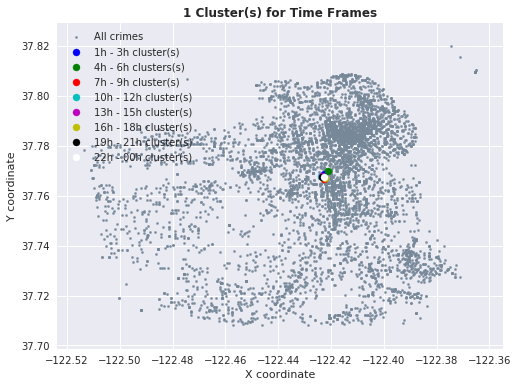

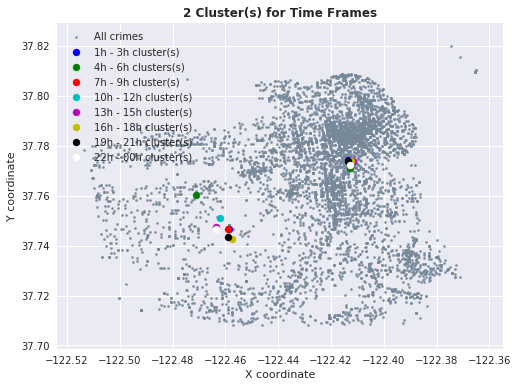

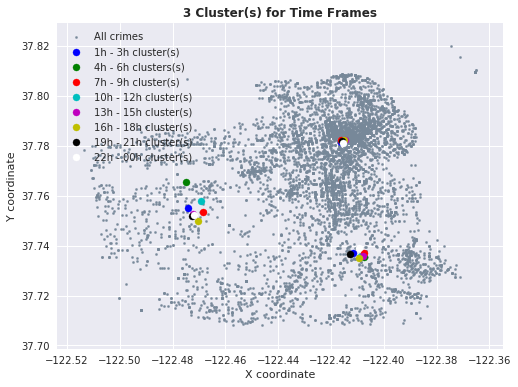

In [110]:
for number_clusters in range(1,4,1):
    kmtime1 = KMeans(number_clusters)
    kmtime2 = KMeans(number_clusters)
    kmtime3 = KMeans(number_clusters)
    kmtime4 = KMeans(number_clusters)
    kmtime5 = KMeans(number_clusters)
    kmtime6 = KMeans(number_clusters)
    kmtime7 = KMeans(number_clusters)
    kmtime8 = KMeans(number_clusters)

    kmtime1_fit = kmtime1.fit(time1X)
    kmtime2_fit = kmtime2.fit(time2X)
    kmtime3_fit = kmtime3.fit(time3X)
    kmtime4_fit = kmtime4.fit(time4X)
    kmtime5_fit = kmtime5.fit(time5X)
    kmtime6_fit = kmtime6.fit(time6X)
    kmtime7_fit = kmtime7.fit(time7X)
    kmtime8_fit = kmtime8.fit(time8X)
    
    togethertime = kcrime1.plot(kind='scatter',x='X',y='Y', c='lightslategray', s=5, figsize=(8, 6))
    pd.DataFrame(kmtime1_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='b',ax=togethertime, s=50)
    pd.DataFrame(kmtime2_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='g',ax=togethertime, s=50)
    pd.DataFrame(kmtime3_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='r',ax=togethertime,s=50)
    pd.DataFrame(kmtime4_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='c',ax=togethertime, s=50)
    pd.DataFrame(kmtime5_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='m',ax=togethertime, s=50)
    pd.DataFrame(kmtime6_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='y',ax=togethertime, s=50)
    pd.DataFrame(kmtime7_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='k',ax=togethertime, s=50)
    pd.DataFrame(kmtime8_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='w',ax=togethertime, s=50)
 
    togethertime.set_title(str(number_clusters) + " Cluster(s) for Time Frames", fontweight='bold')
    togethertime.legend(["All crimes", "1h - 3h cluster(s)", "4h - 6h clusters(s)", "7h - 9h cluster(s)", "10h - 12h cluster(s)\
    ", "13h - 15h cluster(s)", "16h - 18h cluster(s)", "19h - 21h cluster(s)", "22h - 00h cluster(s)"])
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

**Conclusion**<br>
Again, we are unable to draw any valuable conclusions for the graph above. When allowing for 1 cluster, all cluster points virtually have the same position. The same holds for the situation where we allow for 2 and 3 clusters. To conclude, in San Francisco there is no presence of areas where crimes happen during particular times of the day, where in other regions crimes do not happen simultaneously. In each region, every time frame is equally likely to occur.

# Correlation between location and days of the week

In this part, we analyzed whether a correlation is present between days of the week and the location of crimes. Identifying such correlation can be very useful. If for instance, we find that crimes happening on Friday are mostly located outside the city center, police departments can use their resources accordingly. If this is the case, the cluster of Friday would be located outside the city center. We create 7 different categories, one for each day of the week. 

In [111]:
day1 = crimeq[(crimeq['DayOfWeek'] == "Monday")]
day2 = crimeq[(crimeq['DayOfWeek'] == "Tuesday")] 
day3 = crimeq[(crimeq['DayOfWeek'] == "Wednesday")] 
day4 = crimeq[(crimeq['DayOfWeek'] == "Thursday")]
day5 = crimeq[(crimeq['DayOfWeek'] == "Friday")]
day6 = crimeq[(crimeq['DayOfWeek'] == "Saturday")] 
day7 = crimeq[(crimeq['DayOfWeek'] == "Sunday")]

#We have defined those variables here.
day1X = day1[coordinates]
day2X = day2[coordinates]
day3X = day3[coordinates]
day4X = day4[coordinates]
day5X = day5[coordinates]
day6X = day6[coordinates]
day7X = day7[coordinates]

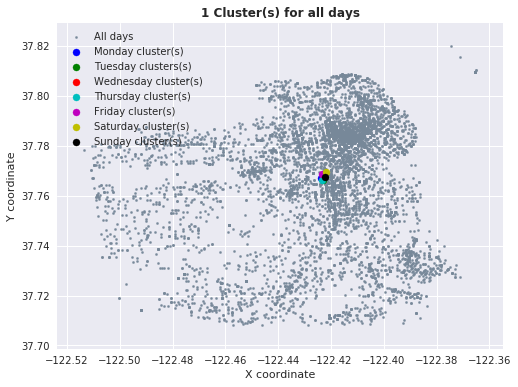

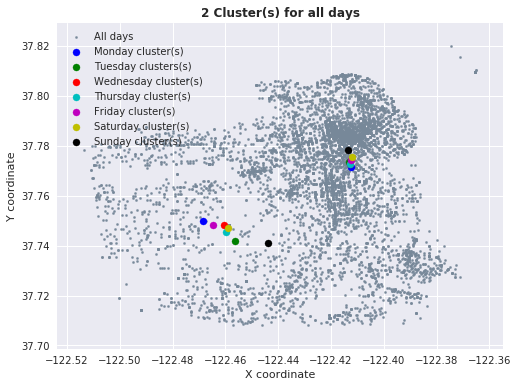

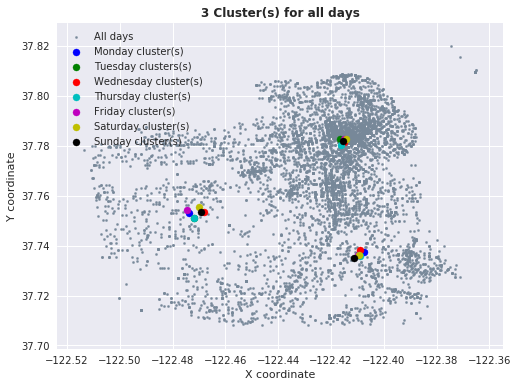

In [114]:
for number_clusters in range(1,4,1):
    kmday1 = KMeans(number_clusters)
    kmday2 = KMeans(number_clusters)
    kmday3 = KMeans(number_clusters)
    kmday4 = KMeans(number_clusters)
    kmday5 = KMeans(number_clusters)
    kmday6 = KMeans(number_clusters)
    kmday7 = KMeans(number_clusters)

    kmday1_fit = kmday1.fit(day1X)
    kmday2_fit = kmday2.fit(day2X)
    kmday3_fit = kmday3.fit(day3X)
    kmday4_fit = kmday4.fit(day4X)
    kmday5_fit = kmday5.fit(day5X)
    kmday6_fit = kmday6.fit(day6X)
    kmday7_fit = kmday7.fit(day7X)

    togetherday = kcrime1.plot(kind='scatter',x='X',y='Y', c='lightslategray', s=5, figsize=(8, 6))
    pd.DataFrame(kmday1_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='b',ax=togetherday, s=50)
    pd.DataFrame(kmday2_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='g',ax=togetherday, s=50)
    pd.DataFrame(kmday3_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='r',ax=togetherday,s=50)
    pd.DataFrame(kmday4_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='c',ax=togetherday, s=50)
    pd.DataFrame(kmday5_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='m',ax=togetherday, s=50)
    pd.DataFrame(kmday6_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='y',ax=togetherday, s=50)
    pd.DataFrame(kmday7_fit.cluster_centers_).plot(kind='scatter',x=0,y=1,color='k',ax=togetherday, s=50)
    
    togetherday.set_title(str(number_clusters) + " Cluster(s) for all days", fontweight='bold')
    togetherday.legend(["All days", "Monday cluster(s)", "Tuesday clusters(s)", "Wednesday cluster(s)", "Thursday cluster(s)\
    ", "Friday cluster(s)", "Saturday cluster(s)", "Sunday cluster(s)"])
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

**Conclusion**<br>
Again, we are unable to find any differences between the location of the clusters. The same holds when we allow for more clusters. We conclude, that there exists no area where crimes happen more frequently on day x of the week and and elsewhere on the other days of the week.

# Conclusion
As we have shown, the k-means clustering is a great method to map (crime) data when you have coordinates available. If we had been able to find differences in the location of the clusters based on time, type or day of the week when allowing for only 1 cluster per category, we would have had a clear conclusion pointing out when and where the San Francisco Police Department should be focussing their resources. Since we were unable to identify significant differences in the location of the clusters, we unfortunately cannot make such recommendations. However based on real life practice, we know that predictive policing is already being tested, so this calls for further research in this field. Can we find significant results if we enlarge the San Francisco dataset? Or can we find significant results for other cities/regions? If we had a dataset of for example, the Netherlands, would we be able to prove that the province of Noord-Brabant is indeed the hotspot of drug related crime as is being claimed regularly? Even though we cannot draw any significant conclusions from our results here, this research can be the basis of future research on this topic. When adding more data or expanding the methods we used here, one might be able to find the patterns in the data we started looking for.